# Using SpeedyWeather. Idealised model: Shallow Water Equations on the Sphere
### Notebook originally created by P.L. Vidale. Minor edits by A. Denvil-Sommer.



The shallow water equations of velocity $\mathbf{u} = (u, v)$ and interface height $\eta$
(i.e. the deviation from the fluid's rest height $H$, therefore the dynamics layer thickness is $h = \eta + H - H_b$) are
formulated in terms of relative vorticity $\zeta = \nabla \times \mathbf{u}$ and
divergence $\mathcal{D} = \nabla \cdot \mathbf{u}$, so that:

$
\begin{aligned}
\frac{\partial \zeta}{\partial t} + \nabla \cdot (\mathbf{u}(\zeta + f)) &=
F_\zeta + \nabla \times \mathbf{F}_\mathbf{u} + (-1)^{n+1}\nu\nabla^{2n}\zeta, \\
\frac{\partial \mathcal{D}}{\partial t} - \nabla \times (\mathbf{u}(\zeta + f)) &=
F_\mathcal{D} + \nabla \cdot \mathbf{F}_\mathbf{u}
-\nabla^2(\tfrac{1}{2}(u^2 + v^2) + g\eta) + (-1)^{n+1}\nu\nabla^{2n}\mathcal{D}, \\
\frac{\partial \eta}{\partial t} + \nabla \cdot (\mathbf{u}h) &= F_\eta,
\end{aligned}
$

The full description of the model, and the solution algorithm, is provided here: [Speedy Shallow Water](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/examples_2D/#Shallow-water-with-mountains)

## 🌊🌍🌀 Exercise: Gravity-Inertia Waves and Equatorially Trapped Waves.
In this exercise we will experiment with GIWs on the sphere, as well as attempt to initiate a Kelvin wave (Equatorially Trapped Waves). For the more adventurous, there is a final optional task at the end of the notebook. 

📌 **Atmospheric waves** include **gravity-inertia waves**, driven by gravity and rotation, and **equatorially trapped waves**, which stay near the equator due to the changing Coriolis effect. These wave types help explain many large-scale tropical and global weather patterns.

First we load the SpeedyWeather package and define the resolution of the simulation with a `SpectralGrid` object.

### 1. Define resolution

In [1]:
using SpeedyWeather
spectral_grid = SpectralGrid(trunc=127, nlayers=1)

SpectralGrid:
├ Spectral:   T127 LowerTriangularMatrix{Complex{Float32}}, radius = 6.371e6 m
├ Grid:       192-ring OctahedralGaussianGrid{Float32}, 40320 grid points
├ Resolution: 112km (average)
├ Vertical:   1-layer atmosphere, 2-layer land
└ Device:     CPU using Array

### 2. Define model components

Now we define the model components that we want to customize, this includes numerics, initial and boundary conditions and output

In [17]:
output = NetCDFOutput(spectral_grid, ShallowWater, id="Bell", output_dt=Minute(60))

# this is a centred semi-implicit scheme, backwards implicit with α=1 dampens gravity waves more
implicit = ImplicitShallowWater(spectral_grid, α=0.5)

orography = NoOrography(spectral_grid)
initial_conditions = StartFromRest()    # but set initial conditions for divergence manually after model construction

# now construct the model by passing all components to the model constructor (";" means they are matched by name)
model = ShallowWaterModel(spectral_grid; orography, initial_conditions, implicit, output)

ShallowWaterModel <: ShallowWater
├ spectral_grid: SpectralGrid
├ device_setup: SpeedyWeather.DeviceSetup{CPU, DataType}
├ geometry: Geometry{Float32, OctahedralGaussianGrid, Vector{Float32}, Vector{Float64}}
├ planet: Earth{Float32}
├ atmosphere: EarthAtmosphere{Float32}
├ coriolis: Coriolis{Float32, Vector{Float32}}
├ orography: NoOrography{Float32, OctahedralGaussianGrid{Float32}, LowerTriangularMatrix{ComplexF32}}
├ forcing: NoForcing
├ drag: NoDrag
├ particle_advection: NoParticleAdvection
├ initial_conditions: StartFromRest{ConstantPressure, JablonowskiTemperature, ZeroInitially}
├ random_process: NoRandomProcess
├ tracers: Dict{Symbol, Tracer}
├ time_stepping: Leapfrog{Float32}
├ spectral_transform: SpectralTransform{Float32, Array, Vector{Float32}, Vector{ComplexF32}, Vector{Int64}, Matrix{ComplexF32}, Array{ComplexF32, 3}, LowerTriangularMatrix{Float32}, LowerTriangularArray{Float32, 2, Matrix{Float32}}}
├ implicit: ImplicitShallowWater{Float32, Vector{Float32}}
├ horizontal_d

If you want to save your output in specific directory you can identify it like this:

output = NetCDFOutput(spectral_grid, ShallowWater, path="**Your_path**", id="Bell", output_dt=Minute(60))

The `model` contains everything that defines the model setup. It does not contain variables and is (almost entirely) constant during simulation.

### 3. Initialize the model

We get the variables packed into a single `simulation` object when we initialize the model, which also initializes all its components

In [18]:
simulation = initialize!(model)

Simulation{ShallowWaterModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::ShallowWaterModel{...}

☝️ Variables in the model are divided into **prognostic variables**, which define the evolving state of the system and are carried forward in time, and **diagnostic variables**, which are calculated from the prognostic ones at each time step but are not retained between steps. 

### 3.1 Manual initial conditions after initialization

At this point the prognostic variable divergence is zero as we set the initial conditions to `StartFromRest`, which is applied in `initialize!(model)`. We now manually redefine the initial conditions of divergence by setting those as follows

In [19]:
div(λ, θ, σ) = min(-1e-4*exp(-((λ-150)^2+θ^2)/(3^2)), 0)
set!(simulation, div=div)

Because SpeedyWeather is a spectral model its prognostic variables (like divergence) are set in spectral space, we therefore have to `transform` them back to grid space to visualise them. Using `CairoMakie` we make a `heatmap` of these initial conditions

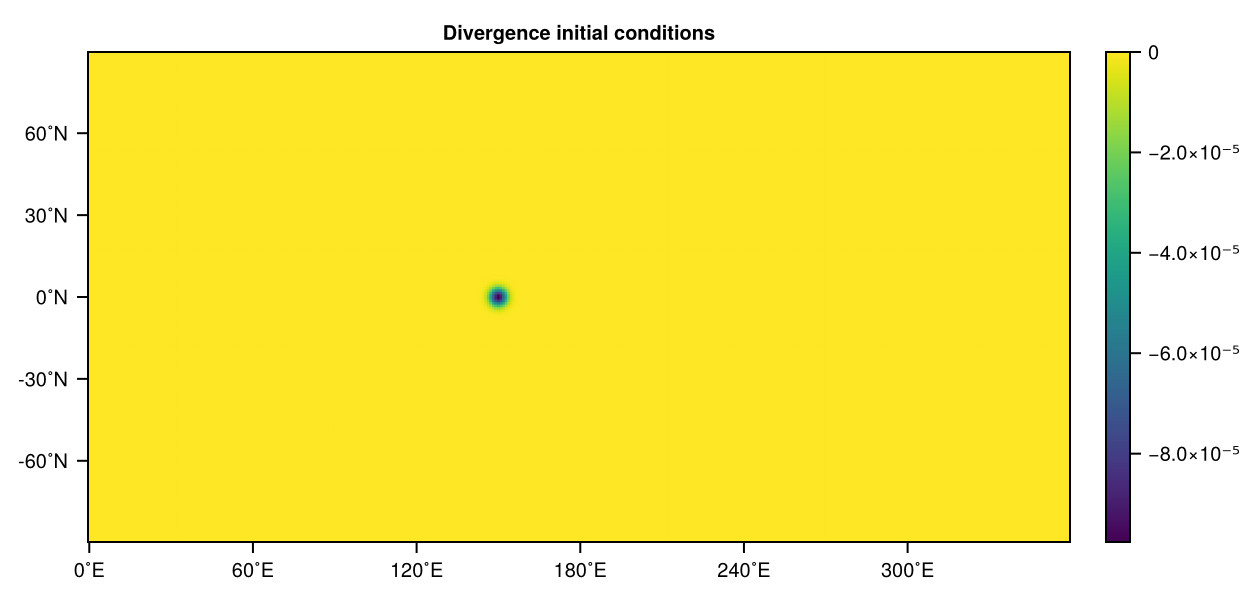

In [20]:
using CairoMakie
heatmap(transform(simulation.prognostic_variables.div[1][:, 1]), title="Divergence initial conditions")

In `div[1][:, 1]` the `[1]` refers to current time step (SpeedyWeather uses a leapfrog scheme so always two steps are stored simulateneously), the `[:, 1]` takes the first (uppermost) layer.

# 4. Run the simulation

Now we run the simulation for one day and visualise the interface displacement (the pressure-equivalent variable in the shallow water model) which is called `pres`. Instead of `transform`ing it like above we can also just read that same variable from the diagnostic variables which has already been transformed (all prognostic variables have to be transformed on every time step).

Weather is speedy: 100%|██████████████████| Time: 0:00:01 (133.27 years/day)


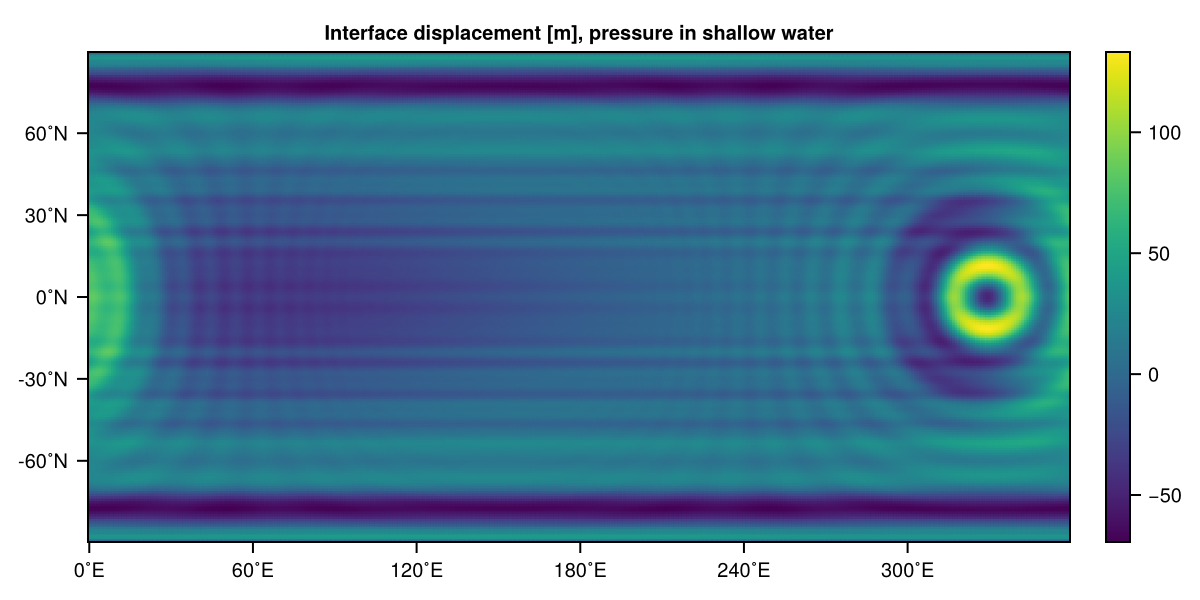

In [21]:
run!(simulation, period=Day(1))

using CairoMakie
heatmap(simulation.diagnostic_variables.grid.pres_grid, title="Interface displacement [m], pressure in shallow water")

### 🧠 Questions on GIWs on the sphere
- what is their speed of propagation? Can you design a type of plot that will allow you to measure that?
- is a semi-implicit scheme really necessary? What happens if you reduce the alpha coefficient in order to approach a nearly explicit time scheme?
- anything else happening in the domain? Why?

### ⛰️🌍🌪️ Now let us try to initiate the same GI waves, albeit with Earth's orography instead of imposing a smooth planet's surface.
🧠 Questions for this new exercise:
- what happens to the GIWs in this case?
- how is orography affecting the waves, that is, what is in fact happening in this type of simulation?


Weather is speedy: 100%|██████████████████| Time: 0:00:00 (353.21 years/day)


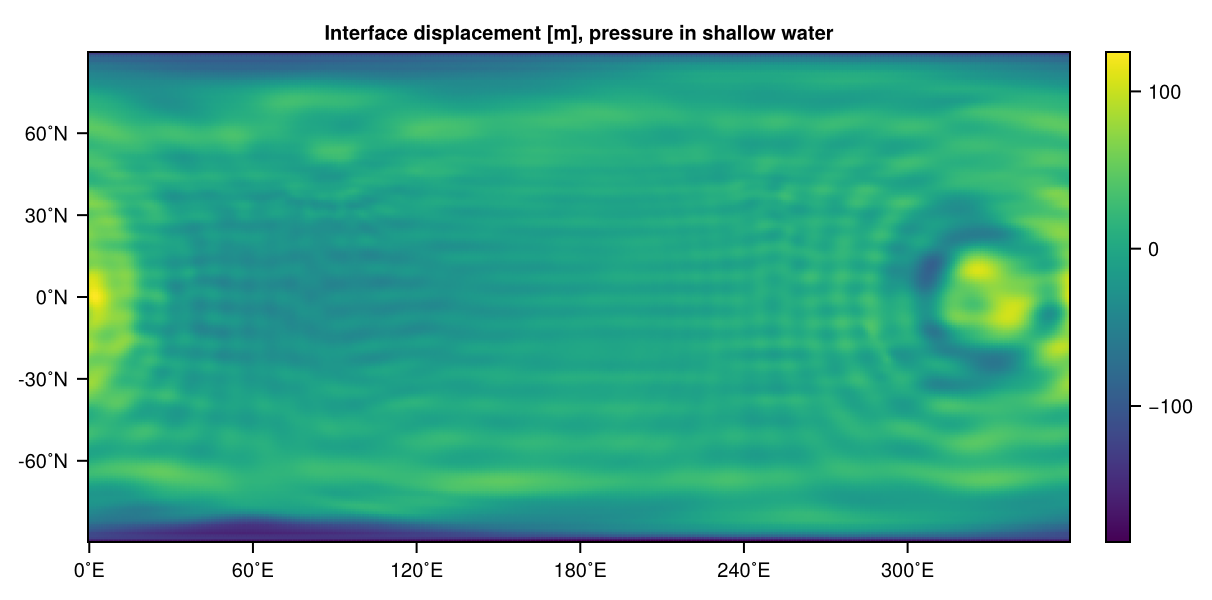

In [22]:
orography = EarthOrography(spectral_grid, smoothing=false)    # redefine orography, reuse other model components 
model = ShallowWaterModel(spectral_grid; orography, initial_conditions, implicit, output)
simulation = initialize!(model)

set!(simulation, div=div)
run!(simulation, period=Day(1))

using CairoMakie
heatmap(simulation.diagnostic_variables.grid.pres_grid, title="Interface displacement [m], pressure in shallow water")

### 🧭⛰️🌬️ Now let us try to initiate the wave at a location very near the "Andes mountains". 
🧠 Questions:
- what happens to the waves in this case?
- how similar or different is this from a typical tsunami, e.g. this: https://www.youtube.com/watch?v=qoxTC3vIF1U

Weather is speedy: 100%|██████████████████| Time: 0:00:02 (86.83 years/day)m


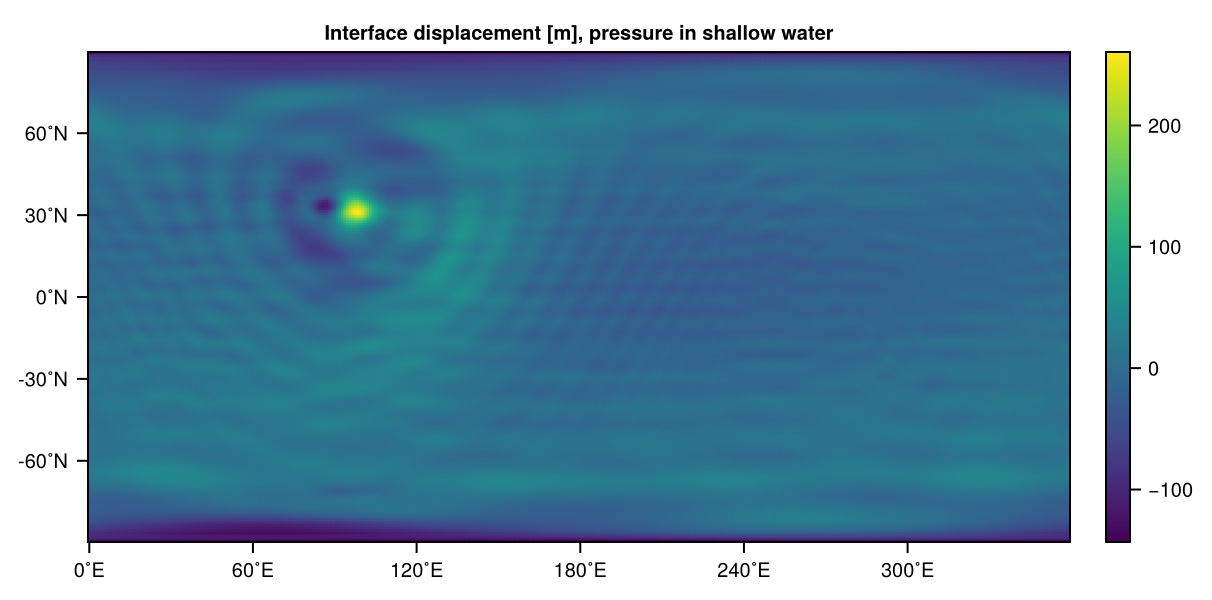

In [23]:
# reinitialize same model to reset the variables
simulation = initialize!(model)

#Now try with the source in the SH hemisphere, near the Andes
div(λ, θ, σ) = min.(-1e-4*exp(-((λ-285)^2+(θ+30)^2)/(3^2)), 0)
set!(simulation, div=div)

run!(simulation, period=Day(1))

using CairoMakie
heatmap(simulation.diagnostic_variables.grid.pres_grid, title="Interface displacement [m], pressure in shallow water")

## 💨🌀🧪 Zonal jet and the Galewski problem

This is a classic benchmark for testing the accuracy and stability of numerical methods in atmospheric models. It features a balanced zonal (eastward) jet with a small perturbation, which evolves into complex wave patterns.

We're also using this example to demonstrate how to save model outputs to NetCDF and later read and plot them using CairoMakie.

✨ Why it's useful:
- The Galewski problem helps evaluate how well your model conserves energy and balances forces over time.

- It reveals if your model handles wave propagation and instabilities realistically.

- It gives you practice with data output workflows, useful in larger model experiments.

👉 Let’s begin by **setting up an entirely new initial conditions** (IC) and visualizing them at time=0.


In [24]:
initial_conditions = ZonalJet()

ZonalJet <: SpeedyWeather.AbstractInitialConditions
├ latitude::Float64 = 45.0
├ width::Float64 = 19.28571428571429
├ umax::Float64 = 80.0
├ perturb_lat::Float64 = 45.0
├ perturb_lon::Float64 = 270.0
├ perturb_xwidth::Float64 = 19.098593171027442
├ perturb_ywidth::Float64 = 3.819718634205488
└ perturb_height::Float64 = 120.0

#### Next, we run a new simulation, to investigate the response of the SWE system is to an IC that has shear in it. 
Note that initially we shall run without any orography. Do follow the instructions for the Graviti-Inertia Waves to try a simulation that includes orography.

🧠 Questions on this Galewski problem:
- What does it mean for the total vorticity field at the start of the simulation? 
- What are the implications of "necessary conditions" for a well-known type of dynamic instability?

In [25]:
output = NetCDFOutput(spectral_grid, ShallowWater, id="Galewski", output_dt=Minute(30))
orography = NoOrography(spectral_grid)
model = ShallowWaterModel(spectral_grid; orography, initial_conditions, output)
simulation = initialize!(model)
run!(simulation, period=Day(6), output=true)

Weather is speedy: run 0004 100%|█████████| Time: 0:00:07 (183.51 years/day)


                      Surface relative vorticity [1/s]                       
       ┌────────────────────────────────────────────────────────────┐0.0001  
    90 │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ ┌──┐   
       │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ │▄▄│   
       │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ │▄▄│   
       │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ │▄▄│   
       │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ │▄▄│   
       │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ │▄▄│   
       │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ │▄▄│   
    ˚N │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ │▄▄│   
       │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ │▄▄│   
       │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ │▄▄│   
       │▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄

#### Notice above how we invoked the writing of our simulation data to NetCDF. Next, we are going to read it back and create some plots with CairoMakie.

In [26]:
id = model.output.id
#id
using NCDatasets
ds = NCDataset("run_$id/output.nc")
ds["vor"]

vor (384 × 192 × 1 × 289)
  Datatype:    Union{Missing, Float32} (Float32)
  Dimensions:  lon × lat × layer × time
  Attributes:
   units                = s^-1
   long_name            = relative vorticity
   _FillValue           = NaN


### First, we plot the initial condition

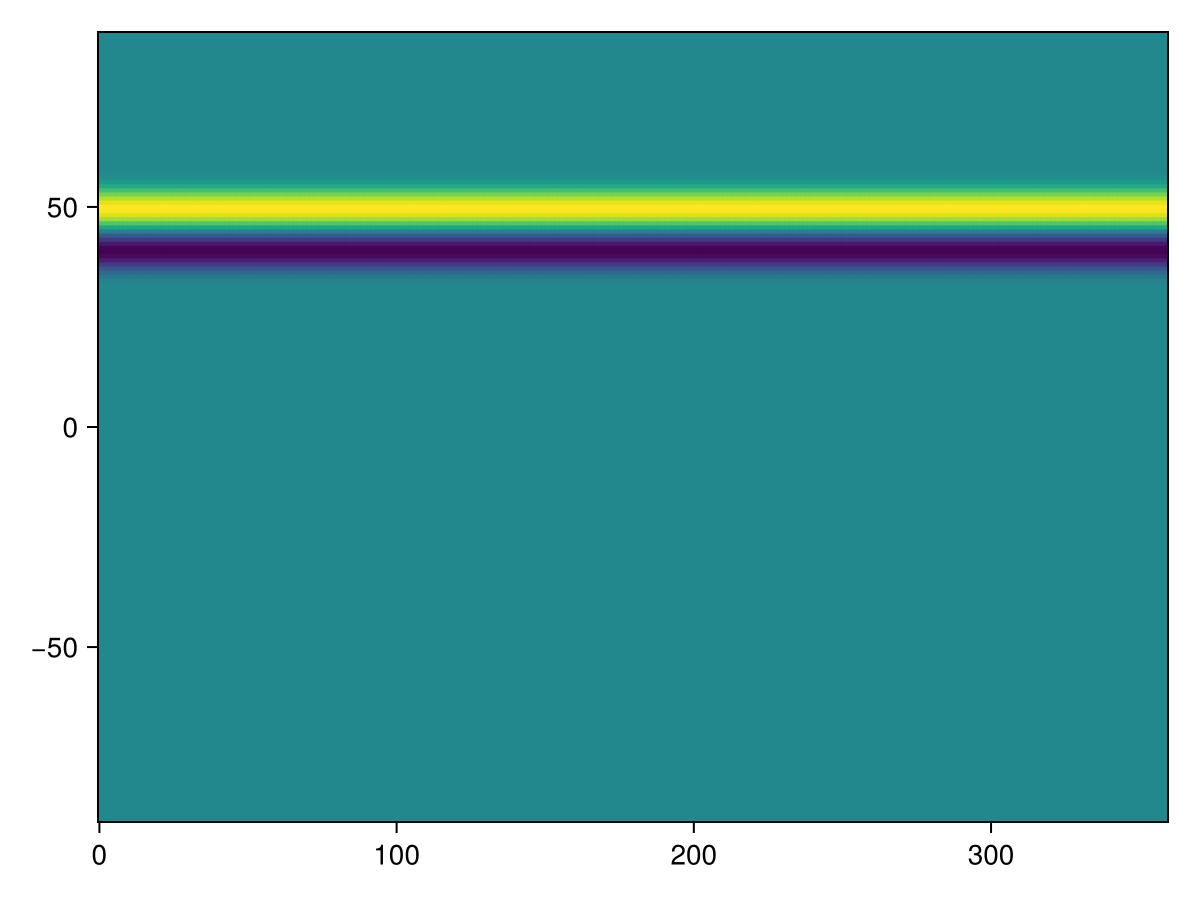

In [27]:
t = 1
vor = Matrix{Float32}(ds["vor"][:, :, 1, t]) # convert from Matrix{Union{Missing, Float32}} to Matrix{Float32}
lat = ds["lat"][:]
lon = ds["lon"][:]

using CairoMakie
heatmap(lon, lat, vor)

### Next, the end state

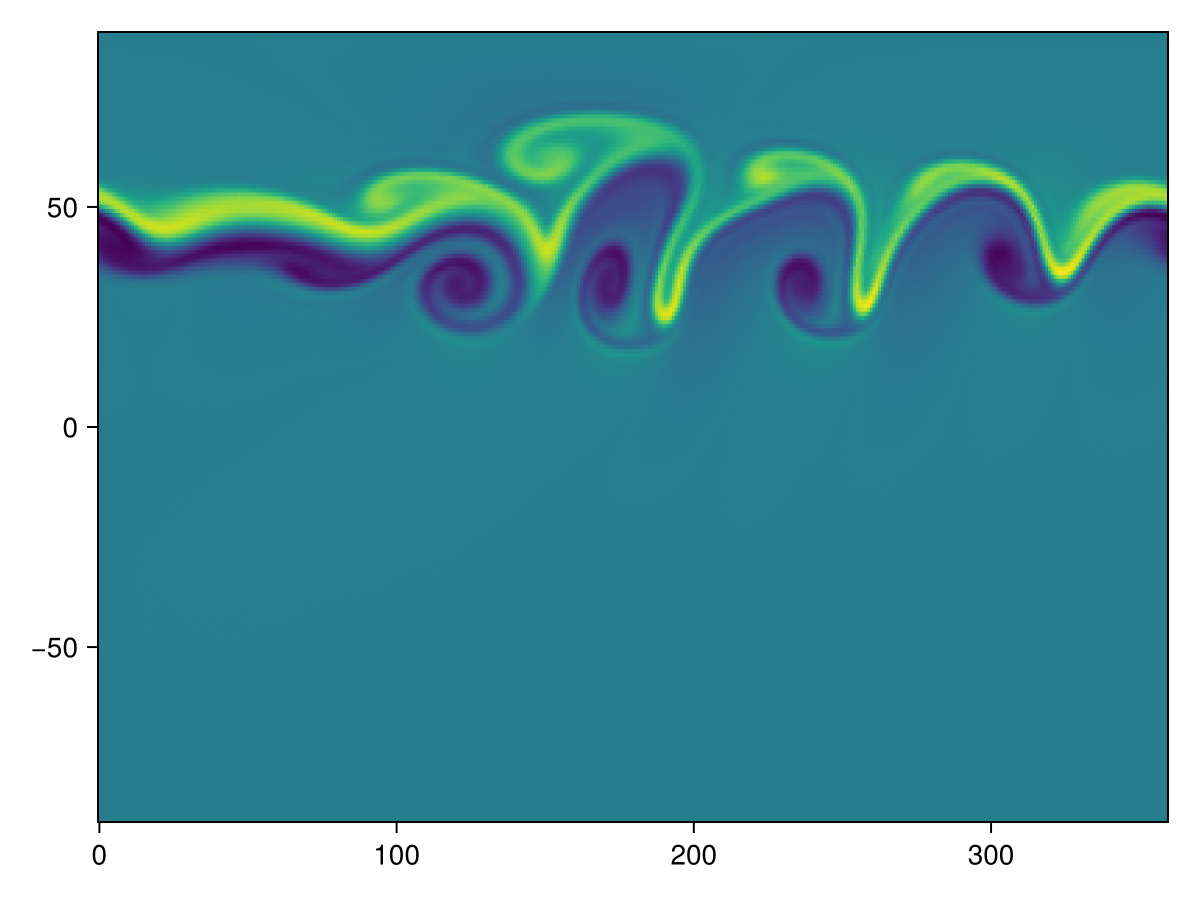

In [28]:
t = 289
vor = Matrix{Float32}(ds["vor"][:, :, 1, t]) # convert from Matrix{Union{Missing, Float32}} to Matrix{Float32}
lat = ds["lat"][:]
lon = ds["lon"][:]
heatmap(lon, lat, vor)

## 🌍🌊🔁 Spawning Equatorially Trapped Waves on the sphere.

These are low-frequency waves trapped near the equator. Similar to gravity-inertia waves, they are triggered by a localized source — but this time, we’re using a time-pulsing forcing term on the right-hand side of the equations.

🔧 Try experimenting with the spatial scale of the forcing and the pulsing frequency. You'll see how different setups affect the structure and behavior of the waves — including how far they reach and how strongly they remain trapped near the equator.

Weather is speedy: run 0005 100%|█████████| Time: 0:00:13 (176.13 years/day)


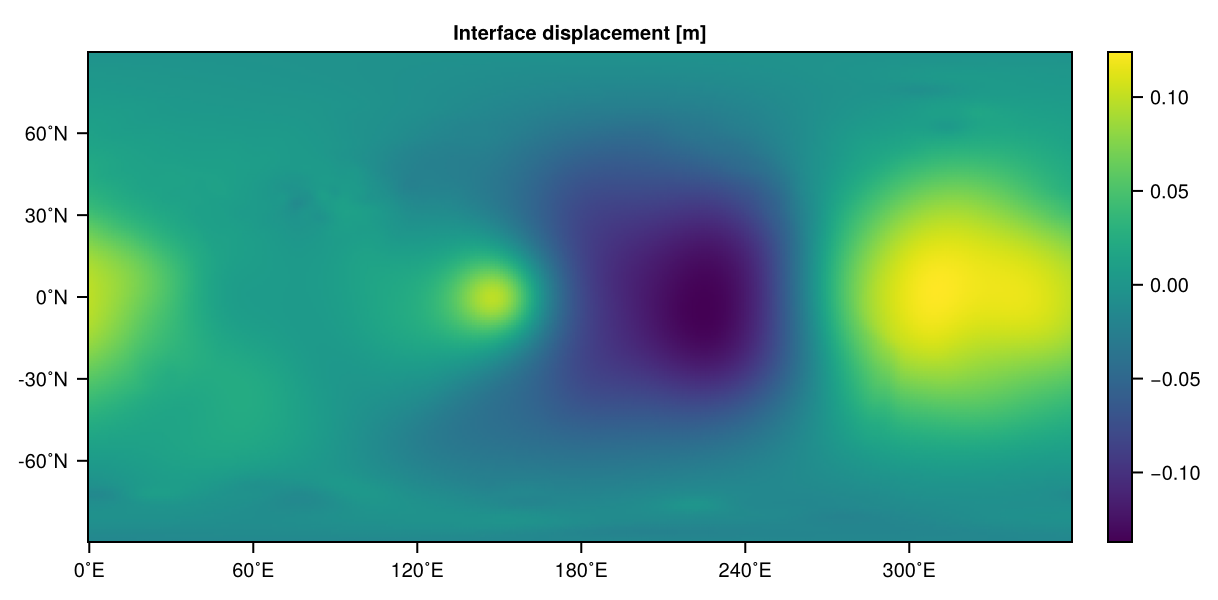

In [29]:
# define new forcing
struct EquatorialPumping <: SpeedyWeather.AbstractForcing end

SpeedyWeather.initialize!(::EquatorialPumping, ::AbstractModel) = nothing

function SpeedyWeather.forcing!(
    diagn::DiagnosticVariables,
    progn::PrognosticVariables,
    forcing::EquatorialPumping,
    lf::Integer,
    model::AbstractModel,
)
    Fη_grid = diagn.tendencies.pres_tend_grid
    Fη = diagn.tendencies.pres_tend

    # time in seconds since start, time scale τ [s]
    (; clock) = progn
    t = Second(clock.time - clock.start).value
    τ = 1*24*3600
    
    # this is a little hacky requiring unfortunately another transform as pres_tend_grid is otherwise not used ... 
    # set in grid space, transform to spectral as pres_tend_grid is not used in the ShallowWaterModel
    set!(Fη_grid, (λ, θ) -> 1000*exp(-((λ-150)^2+θ^2)/(10^2))*sin(2π*t/τ), model.geometry)
    transform!(Fη, Fη_grid, model.spectral_transform)
end

forcing = EquatorialPumping()

implicit = ImplicitShallowWater(spectral_grid, α=0.5)
initial_conditions = StartFromRest() 

model = ShallowWaterModel(spectral_grid; initial_conditions, implicit, forcing, output=output)
simulation = initialize!(model)
run!(simulation, period=Day(10), output=true)

using CairoMakie
heatmap(simulation.diagnostic_variables.grid.pres_grid, title="Interface displacement [m]")


## 🧠 Questions on Equatorially Trapped Waves
- What waves do you see on the Equator?
- Which is the direction of propagation and what is their speed?
- Can you name these waves?
- The way we forced these waves to be trapped has used quite an unrealistic method. Thinking of our real planet, how would one go about creating a total vorticity field that will trap waves within an equatorial channel?
    - If you want to pursue this further, one interim solution (albeit still not realistic) to setting up initial conditions is proposed here: https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/initial_conditions/

## 🚀 Optional exercise for the more adventurous
- Can you think of more planetary waves?
    - Examples are Rosbby waves, as well as Rossby-Haurwitz waves.
- How would you go about spawning them from the theoretical point of view?
    - in practice, see again the page on setting up initial conditions: https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/initial_conditions/

## Appendix: some key information about the SWE in SpeedyWeather

In [30]:
simulation.prognostic_variables

PrognosticVariables{Float32, Array}
├ vor:   T127, 1-layer, 2-steps LowerTriangularArray{Float32}
├ div:   T127, 1-layer, 2-steps LowerTriangularArray{Float32}
├ temp:  T127, 1-layer, 2-steps LowerTriangularArray{Float32}
├ humid: T127, 1-layer, 2-steps LowerTriangularArray{Float32}
├ pres:  T127, 1-layer, 2-steps LowerTriangularArray{Float32}
├ random_pattern: T127, 1-layer LowerTriangularArray{Float32}
├┐ocean: PrognosticVariablesOcean{Float32}
│├ sea_surface_temperature:  192-ring OctahedralGaussianGrid{Float32}
│├ sea_ice_concentration:    192-ring OctahedralGaussianGrid{Float32}
│├ sensible_heat_flux:       192-ring OctahedralGaussianGrid{Float32}
│└ evaporative_flux:         192-ring OctahedralGaussianGrid{Float32}
├┐land:  PrognosticVariablesLand{Float32}
│├ soil_temperature:         2-layer, 192-ring OctahedralGaussianGrid{Float32}
│├ soil_moisture:            2-layer, 192-ring OctahedralGaussianGrid{Float32}
│├ snow_depth:               192-ring OctahedralGaussianGrid{Float32}